## Access Slocum Glider Delayed Qc (Parquet)

This Jupyter notebook demonstrates how to access and plot slocum glider delayed qc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/c317b0fe-02e8-4ff9-96c9-563fd58e82ac).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/slocum_glider_delayed_qc.ipynb).


In [1]:
dataset_name = "slocum_glider_delayed_qc"

## Install/Update packages and Load common functions

In [2]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

Using CPython 3.12.6 interpreter at: /home/lbesnard/miniforge3/envs/AodnCloudOptimised/bin/python
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Audited 240 packages in 55ms


✅ Local version 0.2.1 is up to date (remote: 0.2.1)


In [3]:
from DataQuery import GetAodn, plot_ts_diagram

## Location of the parquet dataset

# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [4]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 72.8 ms, sys: 9.56 ms, total: 82.4 ms
Wall time: 6.64 s


In [5]:
aodn_dataset.dataset.partitioning.schema

deployment_code: string
timestamp: int32
polygon: string

## List unique partition values

In [6]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('deployment_code')
print(list(unique_partition_value)[0:2])  # showing a subset only

['TwoRocks20100628', 'Coffs20111112']
CPU times: user 6.47 ms, sys: 1.84 ms, total: 8.32 ms
Wall time: 7.13 ms


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


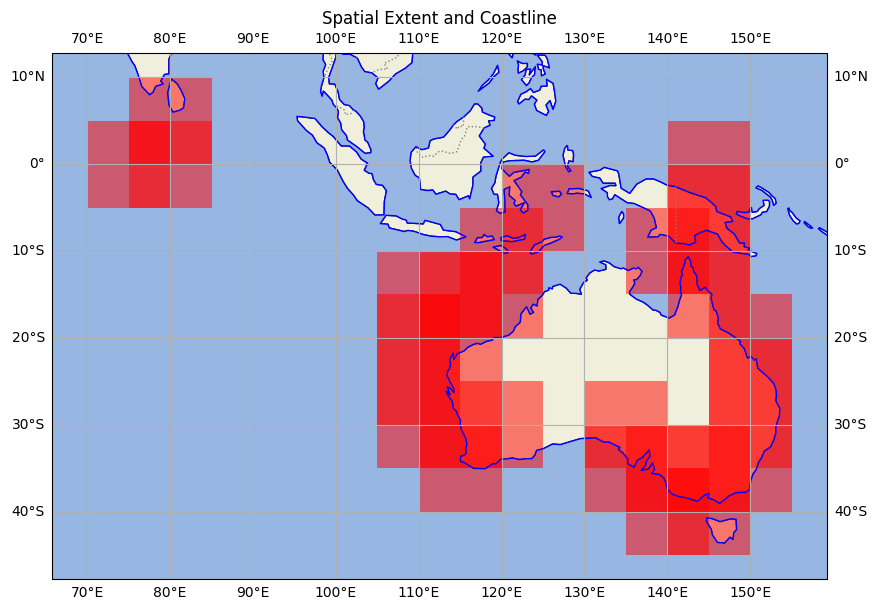

In [7]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset.

In [8]:
aodn_dataset.get_temporal_extent()

(Timestamp('2008-06-21 04:52:31.641139712'),
 Timestamp('2024-06-19 23:47:53.495058944'))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [9]:
metadata = aodn_dataset.get_metadata()
metadata

2025-06-05 13:21:08,417 - aodn.GetAodn - INFO - Retrieving metadata for aodn-cloud-optimised/slocum_glider_delayed_qc.parquet
2025-06-05 13:21:08,620 - aodn.GetAodn - WARNING - Old 'dataset_medata' deprecated key found in parquet schema. Renamed to 'global_attributes'. Dataset should be updated


{'PLATFORM': {'type': 'string',
  'trans_system_id': 'Irridium',
  'positioning_system': 'GPS',
  'platform_type': 'Slocum G2',
  'platform_maker': 'Teledyne Webb Research',
  'firmware_version_navigation': 7.1,
  'firmware_version_science': 7.1,
  'glider_serial_no': '416',
  'battery_type': 'Alkaline',
  'glider_owner': 'CSIRO',
  'operating_institution': 'ANFOG',
  'long_name': 'platform informations'},
 'DEPLOYMENT': {'type': 'string',
  'deployment_start_date': '2015-10-21-T05:00:02Z',
  'deployment_start_latitude': -18.9373,
  'deployment_start_longitude': 146.881,
  'deployment_start_technician': 'Gregor, Rob',
  'deployment_end_date': '2015-10-27-T01:56:23Z',
  'deployment_end_latitude': -19.2358,
  'deployment_end_longitude': 147.5188,
  'deployment_end_status': 'recovered',
  'deployment_pilot': 'pilot, CSIRO',
  'long_name': 'deployment informations'},
 'SENSOR1': {'type': 'string',
  'sensor_type': 'CTD',
  'sensor_maker': 'Seabird',
  'sensor_model': 'GPCTD',
  'sensor_ser

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [10]:
%%time
df = aodn_dataset.get_data(date_start='2020-12-01', date_end='2021-04-01', lat_min=-34, lat_max=-28, lon_min=140, lon_max=160)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369340 entries, 0 to 369339
Data columns (total 62 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   PLATFORM                   369340 non-null  object        
 1   DEPLOYMENT                 369340 non-null  object        
 2   SENSOR1                    369340 non-null  object        
 3   SENSOR2                    369340 non-null  object        
 4   SENSOR3                    369340 non-null  object        
 5   SENSOR4                    369340 non-null  object        
 6   LATITUDE                   369340 non-null  float64       
 7   LATITUDE_quality_control   369340 non-null  float32       
 8   LONGITUDE                  369340 non-null  float64       
 9   LONGITUDE_quality_control  369340 non-null  float32       
 10  TIME                       369340 non-null  datetime64[ns]
 11  TIME_quality_control       369340 non-null  float32 

In [ ]:
# Download subsetted data as CSV
df.aodn.download_as_csv()

## Create a TIME and scalar/number filter

In [11]:
%%time
df = aodn_dataset.get_data(date_start='2024-01-01', date_end='2024-05-01', scalar_filter = {'deployment_code': 'MissionBeach20240120'} )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228684 entries, 0 to 228683
Data columns (total 62 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   PLATFORM                   228684 non-null  object        
 1   DEPLOYMENT                 228684 non-null  object        
 2   SENSOR1                    228684 non-null  object        
 3   SENSOR2                    228684 non-null  object        
 4   SENSOR3                    228684 non-null  object        
 5   SENSOR4                    228684 non-null  object        
 6   LATITUDE                   228684 non-null  float64       
 7   LATITUDE_quality_control   228684 non-null  float32       
 8   LONGITUDE                  228684 non-null  float64       
 9   LONGITUDE_quality_control  228684 non-null  float32       
 10  TIME                       228684 non-null  datetime64[ns]
 11  TIME_quality_control       228684 non-null  float32 

<Axes: title={'center': 'Temperature for each location'}, xlabel='LONGITUDE', ylabel='LATITUDE'>

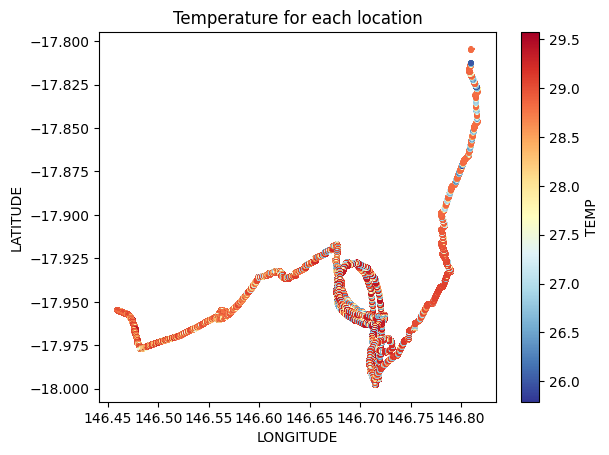

In [12]:
df.plot.scatter(x='LONGITUDE', y='LATITUDE', c='TEMP', marker='+', linestyle="None", cmap='RdYlBu_r', title='Temperature for each location')

/tmp/ipykernel_718897/1403522444.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


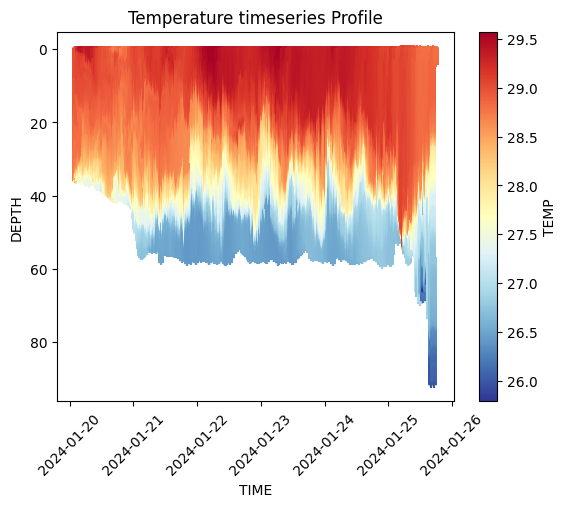

In [13]:
import matplotlib.pyplot as plt
ax = df.plot.scatter(x='TIME', y='DEPTH', c='TEMP', marker='+', linestyle="None", cmap='RdYlBu_r', title='Temperature timeseries Profile')

ax.invert_yaxis()

# Rotate x-axis labels at 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Show the plot
plt.show()

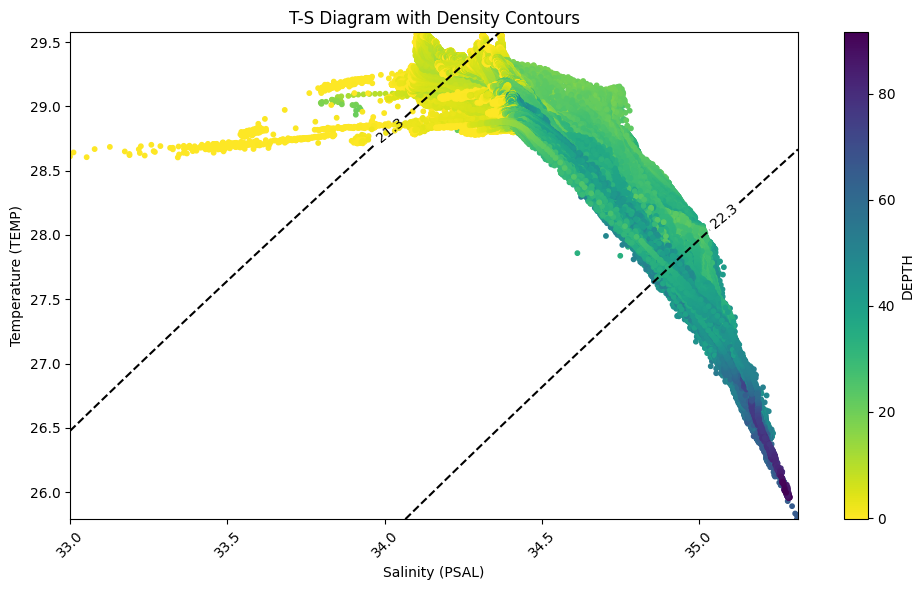

In [14]:
filtered_df = df[(df['PSAL_quality_control'] == 1) & (df['PSAL'] >= 25)]

plot_ts_diagram(filtered_df, temp_col='TEMP', psal_col='PSAL', z_col='DEPTH')